In [21]:
from scipy.integrate import odeint
import numpy as np
import h_transport_materials as htm

ureg = htm.ureg

GAS_CONSTANT = 8.314 * ureg.J * ureg.mol**-1 * ureg.K**-1


In [22]:
def model(c_flibe, t, decay_constant):
    c_inf = 1
    dcdt = decay_constant * (c_inf - c_flibe)
    return dcdt


In [23]:
diffusivities = htm.diffusivities.filter(material="flibe", isotope="t")
mean_diff = htm.Diffusivity(*diffusivities.mean())
print(mean_diff)



        Author: 
        Material: 
        Year: None
        Isotope: None
        Pre-exponential factor: 5.729948226646946e-07 m ** 2 / s
        Activation energy: 0.37535747466879604 eV
        


In [24]:
solubilities = htm.solubilities.filter(material="flibe", isotope="t")
mean_sol = htm.Solubility("m-3 Pa-1", *solubilities.mean())
print(mean_sol)



        Author: 
        Material: 
        Year: None
        Isotope: None
        Pre-exponential factor: 4.757491200400059e+22 particle / Pa / m ** 3
        Activation energy: 0.3627494379691766 eV
        


In [25]:
def compute_characteristic_time(T, radius):
    K_H = mean_sol.value(T.to(ureg.K).magnitude) * mean_sol.units
    D = mean_diff.value(T.to(ureg.K).magnitude) * mean_diff.units
    time = 1 / (K_H * D * GAS_CONSTANT * T.to(ureg.K) * 3 / radius**2)
    return time.to(ureg.s)


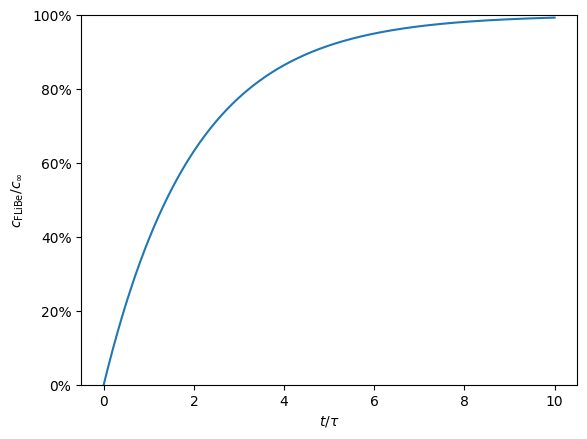

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

c_flibe_0 = 0
tau = 2
t = np.linspace(0, 5 * tau, num=500)

y = odeint(model, c_flibe_0, t, args=(1 / tau,))

plt.plot(t, y, color="tab:blue")

plt.xlabel(r"$t/\tau$")
plt.ylabel("$c_\mathrm{FLiBe}/c_\infty$")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()


[Text(0.253, 4.7567454699726905, 'T=500.0 °C'),
 Text(0.40149999999999997, 4.097062162078846, 'T=575.0 °C'),
 Text(0.55, 3.1087680642516107, 'T=650.0 °C'),
 Text(0.6985, 2.309057002267568, 'T=725.0 °C'),
 Text(0.847, 1.7334423649969006, 'T=800.0 °C')]

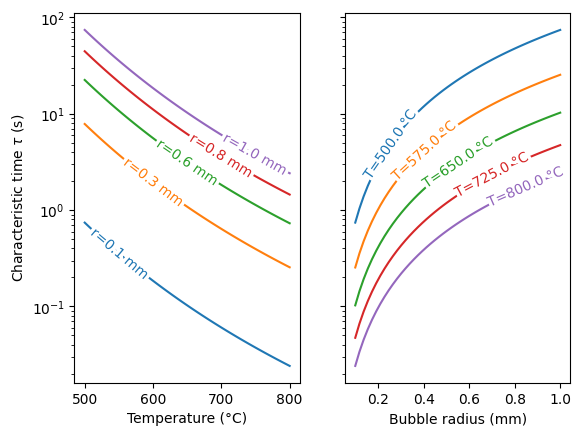

In [27]:
from labellines import labelLines

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)


# vary temperature
plt.sca(axs[0])
T_range = np.linspace(500, 800) * ureg.degC
radii = np.linspace(0.1, 1, num=5) * ureg.mm

for radius in radii:
    plt.plot(
        T_range,
        compute_characteristic_time(T_range, radius).to(ureg.s),
        label=f"r={radius:~.1f}",
    )

# vary radius
plt.sca(axs[1])

radius_range = np.linspace(0.1, 1) * ureg.mm
temperatures = np.linspace(500, 800, num=5) * ureg.degC

for T in temperatures:
    plt.plot(
        radius_range,
        compute_characteristic_time(T, radius_range).to(ureg.s),
        label=f"T={T:~.1f}",
    )

axs[0].set_ylabel(r"Characteristic time $\tau$ (s)")
axs[0].set_xlabel(f"Temperature ({T_range.units: ~P})")
axs[1].set_xlabel(f"Bubble radius ({radius_range.units: ~P})")
plt.yscale("log")

labelLines(axs[0].get_lines(), zorder=2.5)
labelLines(axs[1].get_lines(), zorder=2.5)


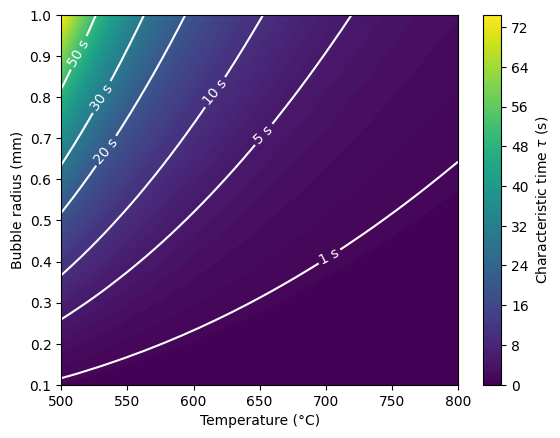

In [28]:
from matplotlib import ticker, cm, colors

XX, YY = np.meshgrid(T_range, radius_range)
ZZ = compute_characteristic_time(XX, YY)
cs = plt.contourf(XX, YY, ZZ, levels=100)
cs2 = plt.contour(
    XX,
    YY,
    ZZ,
    levels=[1, 5, 10, 20, 30, 50],
    colors="white",
)


def fmt(x):
    return f"{x:.0f} {ZZ.units:~P}"


plt.clabel(cs2, cs2.levels, inline=True, fontsize=10, fmt=fmt)

plt.xlabel(f"Temperature ({T_range.units: ~P})")
plt.ylabel(f"Bubble radius ({radius_range.units: ~P})")
cbar = fig.colorbar(cs, label=r"Characteristic time $\tau$ (s)")
